## Drawing KEGG global and overview map

In [2]:
import pykegg
import requests_cache
from plotnine import (
    ggplot,
    geom_point,
    aes,
    geom_segment,
    theme_void,
    options
)
import warnings
warnings.filterwarnings('ignore')

## Cache all the downloaded files
requests_cache.install_cache('pykegg_cache')
graph = pykegg.KGML_graph(pid="ko01100")

In [3]:
nodes = graph.get_nodes()
coords = graph.get_coords()

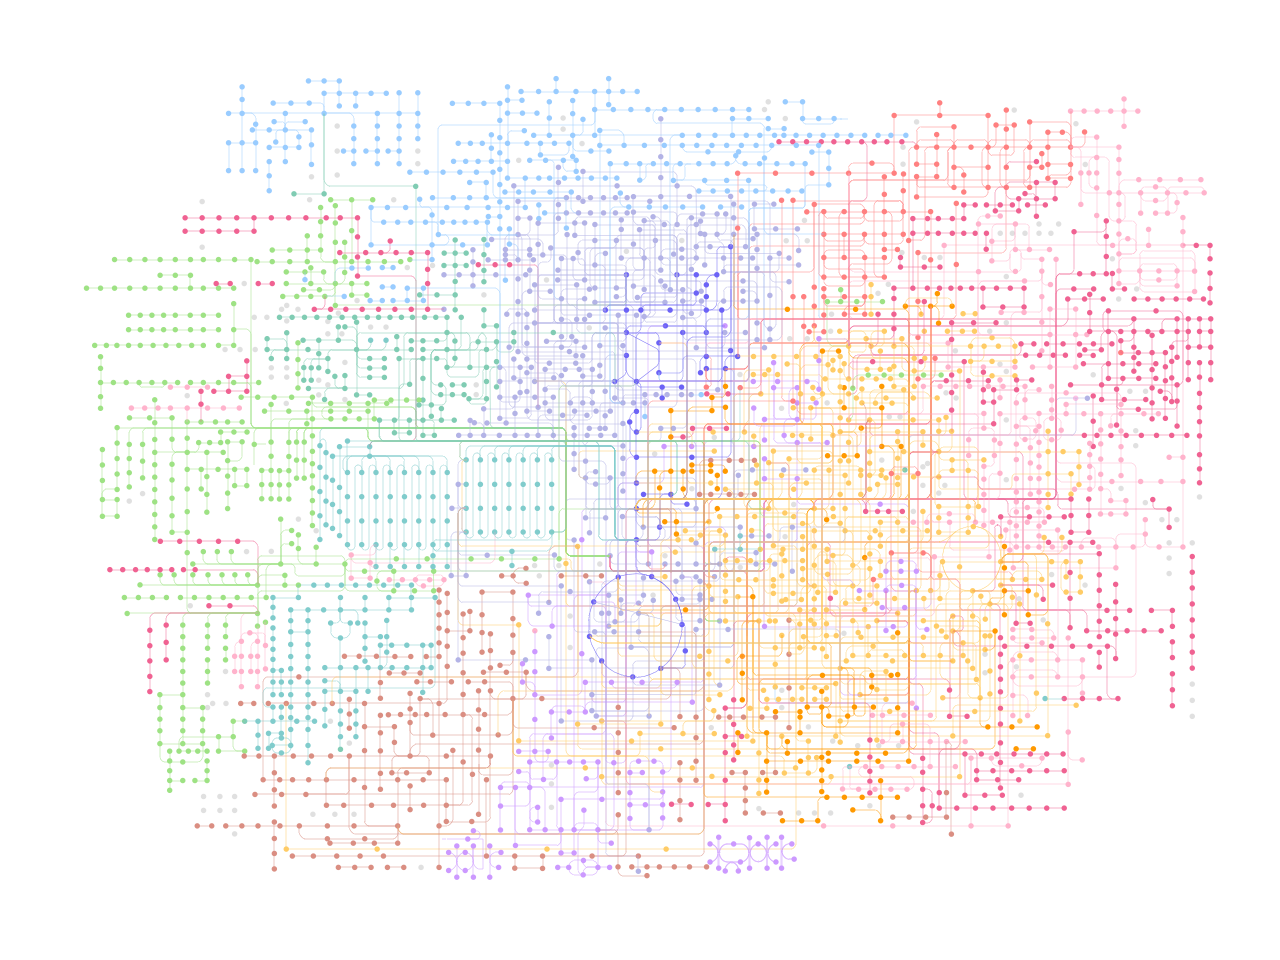

<Figure Size: (640 x 480)>

In [4]:
## Plot without map nodes
(ggplot() + 
 geom_point(aes(x="x", y="y"), size=0.1,
            data=nodes[nodes.original_type!="map"], color=nodes[nodes.original_type!="map"].fgcolor.tolist())+
 geom_segment(aes(x="x", y="y", xend="xend", yend="yend"),
              color=coords.fgcolor.tolist(), data=coords,
             size=0.1)+
 theme_void())

### Colorize edges based on KO values

We obtained the data from the metagenomic study of Crohn's disease patient ([He et al. 2017. GigaScience](https://doi.org/10.1093/gigascience/gix050)). Specifically, from [GigaDB](http://gigadb.org/dataset/100317), the abundance of KEGG Orthology is downloaded. The log2 fold change of mean abundance values were obtained between samples with column name starting with `CD` and `CT`.

In [6]:
import pandas as pd
import numpy as np
ko = pd.read_csv("../KO.profile", sep="\t", index_col=0)

In [7]:
cd = [i for i in ko.columns if "CD" in i]
ct = [i for i in ko.columns if "CT" in i]
cd_mean = ko.loc[:,cd].apply(lambda x: x.mean(), axis=1)
ct_mean = ko.loc[:,ct].apply(lambda x: x.mean(), axis=1)
lfc_dict = np.log2(cd_mean / ct_mean).to_dict()

In [8]:
discard = [i for i in lfc_dict.keys() if lfc_dict[i] == np.inf] + [i for i in lfc_dict.keys() if lfc_dict[i] == -1*np.inf]
for d in discard:
    del lfc_dict[d]

In [23]:
coords = pykegg.append_colors_continuous_values(coords, lfc_dict, "name", center_value=0)

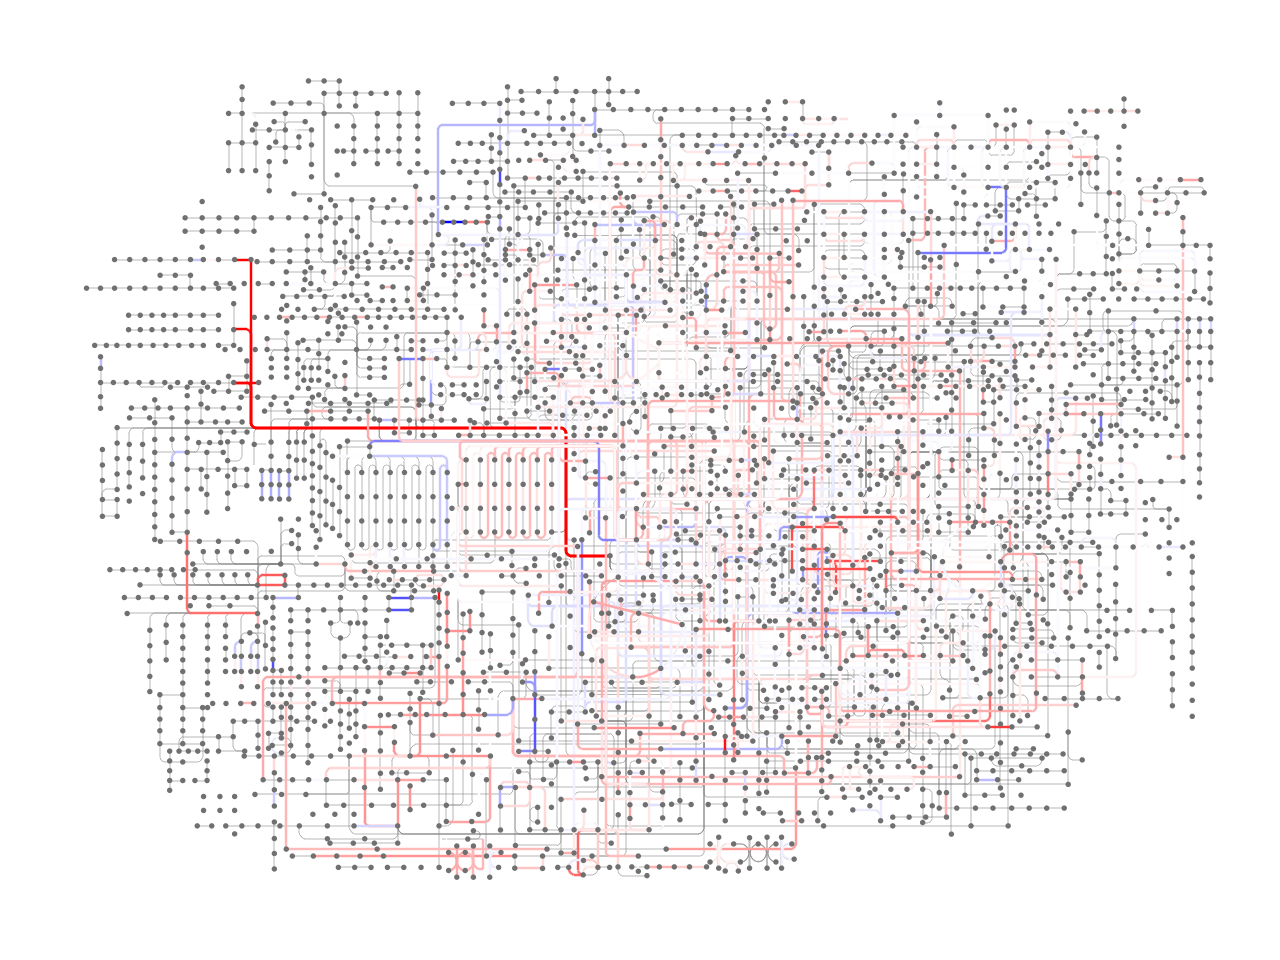

<Figure Size: (640 x 480)>

In [24]:
## Plot without map nodes
(ggplot() + 
 geom_segment(aes(x="x", y="y", xend="xend", yend="yend"),
              color="#707070", data=coords, size=0.1)+
 geom_segment(aes(x="x", y="y", xend="xend", yend="yend"),
              color=coords[coords.color.apply(lambda x: x is not None)].color.tolist(),
              data=coords[coords.color.apply(lambda x: x is not None)],
              size=0.5)+
 geom_point(aes(x="x", y="y"), size=0.1,
            data=nodes[nodes.original_type!="map"], color="#707070")+
 theme_void())